In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\Users\celes\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
""" The following codes show how to get stock data from yfinance and then compute well known technical indicators:
I will periodically add more indicators.

 RSI - Relative Strength Index.
 MFI - Money Flow Index. 
 MACD - Moving Average Convergence Divergence."""

' The following codes show how to get stock data from yfinance and then compute well known technical indicators:\nI will periodically add more indicators.\n\n RSI - Relative Strength Index.\n MFI - Money Flow Index. \n MACD - Moving Average Convergence Divergence.'

### Get Stock Data

In [60]:
#ticker = 'JUN3.F' ### stock ticker
ticker = 'JEN.F'
#ticker = '4A3.F'

data = []
data = yf.download(ticker, start='2024-01-01', end='2025-02-14', progress=False)
data = data[['Close','High','Low', 'Volume']] ### To compute RSI and MFI we only need these quantities

### Fill Forward -- Weekends and periods where the market ist not operating, for example weekends.
idx = pd.date_range(data.index[0], data.index[-1])
data = data.reindex(idx)
data.ffill(inplace=True)

data.head()

,Close,High,Low,Volume
2024-01-02,27.980000,28.42,27.980000,1850.0
2024-01-03,26.379999,27.74,26.379999,370.0
2024-01-04,26.160000,26.16,26.139999,50.0
2024-01-05,25.620001,26.02,25.620001,110.0
2024-01-06,25.620001,26.02,25.620001,110.0


### RSI - Relative Strength Index

In [61]:
### RSI - Relative Strength Index

### References
### https://wire.insiderfinance.io/calculate-rsi-with-python-and-yahoo-finance-c8fb78b1c199

window = 14 ### how many past days to consider in the exponentially weighted calculations.
adjust = False

delta = []
delta = data['Close'].diff(1) ### compute the price difference

loss = delta.copy()
gains = delta.copy()

gains[gains < 0] = 0
loss[loss > 0] = 0

gain_ewm = gains.ewm(com=window - 1, adjust=adjust).mean()
loss_ewm = abs(loss.ewm(com=window - 1, adjust=adjust).mean())

RS = []
RS = gain_ewm / loss_ewm

RSI = []
RSI = 100 - 100 / (1 + RS)
RSI = pd.DataFrame(RSI)
RSI.rename(columns={"Close": "RSI"}, inplace=True)

data = data.join(RSI) ### append RSI to data

data.head()

,Close,High,Low,Volume,RSI
2024-01-02,27.980000,28.42,27.980000,1850.0,NaN
2024-01-03,26.379999,27.74,26.379999,370.0,0.0
2024-01-04,26.160000,26.16,26.139999,50.0,0.0
2024-01-05,25.620001,26.02,25.620001,110.0,0.0
2024-01-06,25.620001,26.02,25.620001,110.0,0.0


### MFI - Money Flow Index

In [62]:
### References
### https://www.investopedia.com/terms/m/mfi.asp
### https://en.wikipedia.org/wiki/Money_flow_index

### Calculate the typical price and money flow

typical_price = []
typical_price  = data[['Close', 'High', 'Low']].sum(axis=1)/3 ### (Close + High + Low)/3

money_flow = []
money_flow = typical_price * data['Volume']

### For each period, mark whether the typical price was higher or lower than the prior period. 
### This will tell you whether raw money flow is positive or negative.

### Positive money flow is calculated by adding the money flow of all the 
### days where the typical price is higher than the previous day's typical price.

positive_flow = []
negative_flow = []

# Loop through the typical price
for i in range(0, len(typical_price)):

    if i == 0: ### money flow is not defined (there is no "previous typical price")
        positive_flow.append(0)
        negative_flow.append(0)

    else:
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i])
            negative_flow.append(0)

        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i])
            positive_flow.append(0)

        else:
            positive_flow.append(0)
            negative_flow.append(0)

positive_flow = pd.Series(positive_flow)
negative_flow = pd.Series(negative_flow)

# Get all of the positive and negative money flows within the time period

positive_mf = []
negative_mf = []

positive_mf = positive_flow.ewm(com=window - 1, adjust=adjust).mean()
negative_mf = negative_flow.ewm(com=window - 1, adjust=adjust).mean()

# Calculate the money flow index

MFI = []
MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))
MFI = pd.DataFrame(MFI, columns=['MFI'])
MFI.set_index([data.index],inplace=True)

data = data.join(MFI) ### append MFI to data

data.head()

C:\Users\celes\AppData\Local\Temp\ipykernel_10680\3511559677.py:56: RuntimeWarning: invalid value encountered in divide
  MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))


,Close,High,Low,Volume,RSI,MFI
2024-01-02,27.980000,28.42,27.980000,1850.0,NaN,NaN
2024-01-03,26.379999,27.74,26.379999,370.0,0.0,0.0
2024-01-04,26.160000,26.16,26.139999,50.0,0.0,0.0
2024-01-05,25.620001,26.02,25.620001,110.0,0.0,0.0
2024-01-06,25.620001,26.02,25.620001,110.0,0.0,0.0


### Plot Output RSI und MFI

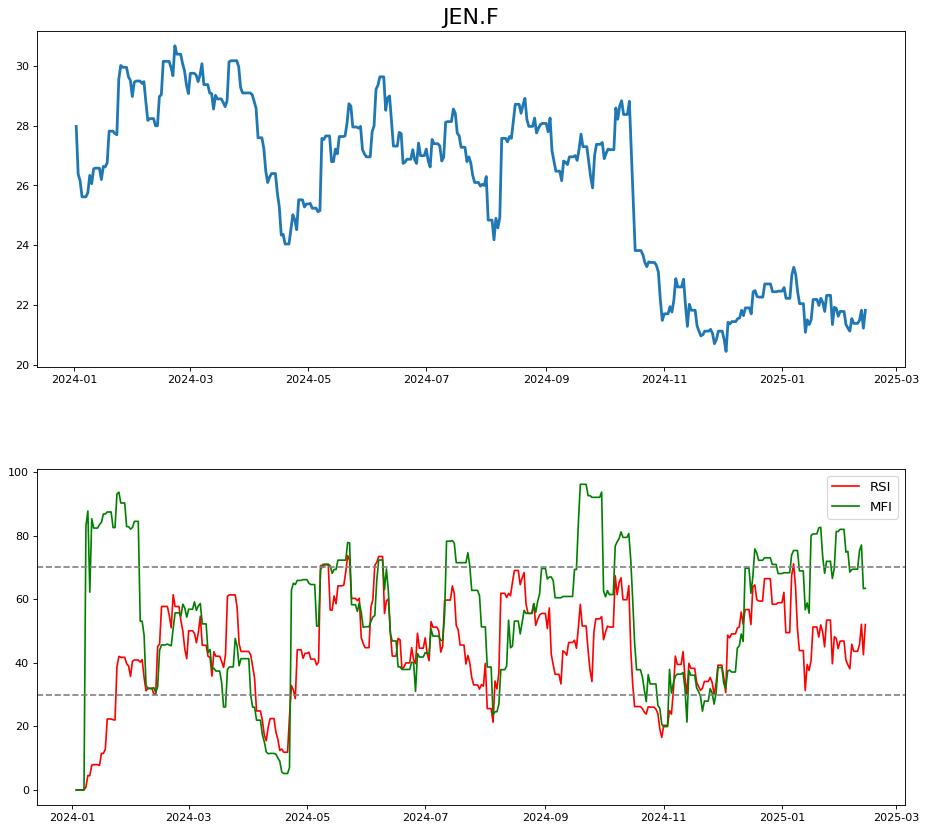

In [63]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(ticker, fontsize=20)
ax2.plot(data['RSI'], color='red', linewidth=1.5)
ax2.plot(data['MFI'], color='green', linewidth=1.5)
ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['RSI', 'MFI'], fontsize=12)

plt.show()

 ## MACD - Moving Average Convergence Divergence

In [64]:
### References
### https://medium.com/@financial_python/building-a-macd-indicator-in-python-190b2a4c1777
### https://medium.com/@teopan00/macd-indicator-for-algorithmic-trading-in-python-ce2833993550

In [65]:
# Calculate the 12-period EMA
ema12 = []
ema12 = data['Close'].ewm(span=12, adjust=False).mean()

# Calculate the 26-period EMA
ema26 = []
ema26 = data['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD (the difference between 12-period EMA and 26-period EMA)
# Typically, widely-accepted values for the fast and slow lengths are 12 and 26, respectively. 
# The final values of the MACD line are determined by subtracting the EMA with the slow length from 
# the EMA with the fast length.

macd = []
macd = ema12 - ema26 ### fast - slow

# Calculate the 9-period EMA of MACD (Signal Line)
# The commonly used period for computing the Signal line is 9. 
# Since the Signal line averages out the MACD line, it tends to offer a smoother representation of trends.

signal_line = []
signal_line = macd.ewm(span=9, adjust=False).mean()

### Add MACD and Signal_line to dataframe

macd = pd.DataFrame(macd)
macd.rename(columns={"Close": "MACD"}, inplace=True)
macd.set_index([data.index],inplace=True)

signal_line = pd.DataFrame(signal_line)
signal_line.rename(columns={"Close": "Signal_Line"}, inplace=True)
signal_line.set_index([data.index],inplace=True)

# If MACD is above the signal line, the histogram will be above the MACD’s baseline or zero line. 
# If MACD is below its signal line, the histogram will be below the MACD’s baseline. 
# Traders use the MACD’s histogram to identify peaks of bullish or bearish momentum, 
# and to generate overbought/oversold trade signals.

data = data.join(macd) ### append MACD to data
data = data.join(signal_line) ### append Signal_Line to data
data.tail()

,Close,High,Low,Volume,RSI,MFI,MACD,Signal_Line
2025-02-09,21.379999,21.379999,21.360001,25.0,43.592000,69.412204,-0.194586,-0.166942
2025-02-10,21.480000,21.500000,21.180000,1377.0,45.659549,75.267769,-0.182745,-0.170103
2025-02-11,21.820000,21.820000,21.540001,505.0,52.089503,77.031927,-0.144263,-0.164935
2025-02-12,21.219999,21.900000,21.100000,1447.0,42.526373,63.303531,-0.160332,-0.164014
2025-02-13,21.820000,21.820000,21.200001,20.0,52.013845,63.401555,-0.123232,-0.155858


### Plot MACD

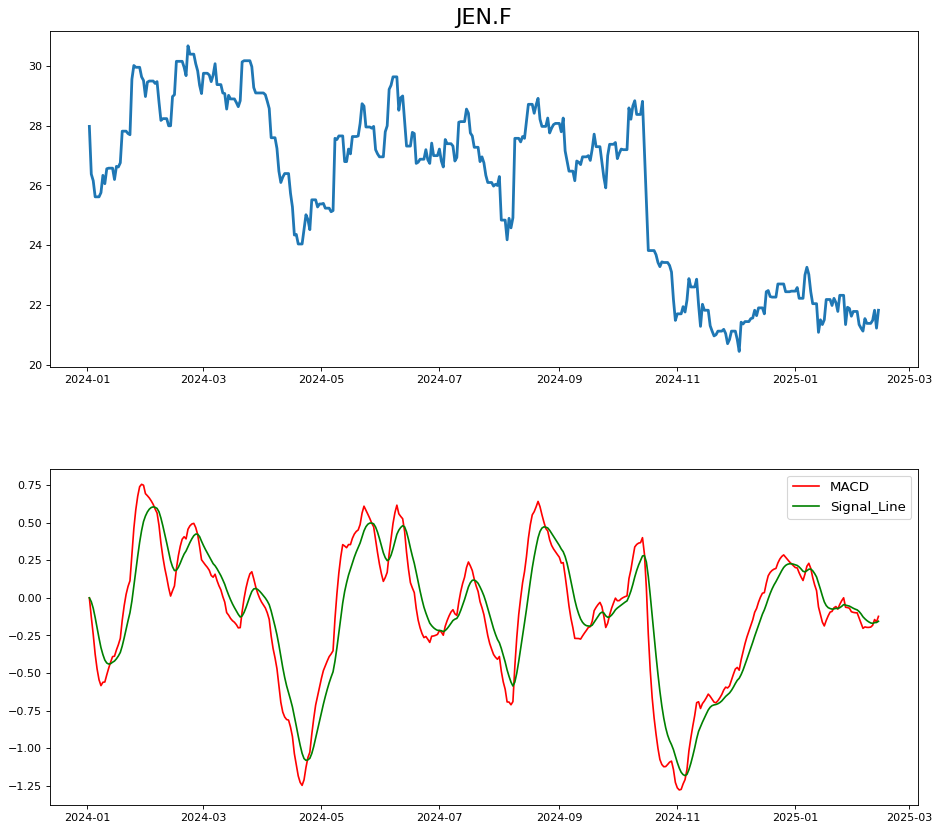

In [66]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(ticker, fontsize=20)
ax2.plot(data['MACD'], color='red', linewidth=1.5)
ax2.plot(data['Signal_Line'], color='green', linewidth=1.5)
#ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['MACD', 'Signal_Line'], fontsize=12)

plt.show()